In [1]:
"""Explore the behaviour of optimal solution of linear masked autoencoder for multiple samples."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Note prob is the masked probability
"""
def binary_mat_generator(prob, m, n):
    num0 = int(n*prob) # num1 of entries is 1 in every row
    num1 = n - num0
    vec = np.concatenate([np.zeros(num0), np.ones(num1)])
    mat = np.tile(vec, (m, 1))
    idx = np.random.rand(*mat.shape).argsort(axis=1)
    mat_shuffle = np.take_along_axis(mat, idx, axis=1)
    return torch.tensor(mat_shuffle).float()
"""
    
def binary_mat_generator(prob, m, n):
    mat_zero = torch.zeros(m, n)
    return mat_zero.bernoulli(1-prob)


In [3]:
# Masked autoencoder (linear)
class M_LAE(nn.Module):
    def __init__(self, prob, m, n):
        super(M_LAE, self).__init__()
        self.prob = prob
        self.m = m
        self.n = n
        w1 = nn.Linear(n, n, bias=False)
        w2 = nn.Linear(n, n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X, mask=None):
        if mask is None:
            mask = binary_mat_generator(self.prob, self.m, self.n)
        Y = mask * X
        Y = self.body(Y)
        return Y

In [4]:
prob = 0.5
m = 200
n = 50

inputs = torch.rand(m, n) * 2
targets = inputs

In [5]:
m_net = M_LAE(prob, m, n)

learning_rate = 0.0001
epochs = 40000
counter = 5000
criterion = nn.MSELoss()
optimizer = optim.Adam(m_net.body.parameters(), lr=learning_rate)

In [6]:
"""
# version 1
loss_plt = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = m_net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    loss_plt.append(loss.item())
    if epoch % counter == 0:
        print('epoch: ', epoch, 'loss: ', loss.item())
    if epoch == 6000:
        learning_rate /= 3
        optimizer = optim.Adam(m_net.body.parameters(), lr=learning_rate)
"""

# version 2
N = 30
loss_plt = []
for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()
    #N = torch.randint(20, 60, (1,))[0]
    for i in range(N):
        outputs = m_net(inputs)
        loss = criterion(outputs, targets)
        loss_total += loss
    loss_total /= N
    loss_total.backward()
    optimizer.step()
    loss_plt.append(loss_total.item())
    if epoch % counter == 0:
        print('epoch: ', epoch, 'loss: ', loss_total.item())
    if epoch % 10000 == 0:
        learning_rate /= 4
        optimizer = optim.Adam(m_net.body.parameters(), lr=learning_rate)

epoch:  0 loss:  1.476137638092041
epoch:  5000 loss:  0.31907784938812256
epoch:  10000 loss:  0.27722200751304626
epoch:  15000 loss:  0.2750692069530487
epoch:  20000 loss:  0.27519041299819946
epoch:  25000 loss:  0.27479082345962524
epoch:  30000 loss:  0.2745460569858551
epoch:  35000 loss:  0.2752232551574707


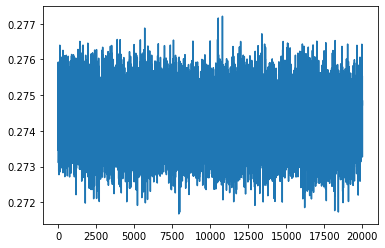

In [13]:
plt.plot(loss_plt[-20000:])

In [8]:
params = list(m_net.body.parameters())

In [9]:
W1 = params[0].requires_grad_(False)
W2 = params[1].requires_grad_(False)

In [27]:
N = 1000
gradient1 = 0
gradient2 = 0
X = inputs
for i in range(N):
    Y = torch.mul(binary_mat_generator(prob, m, n), X)
    gradient1 += W2.T @ (W2@W1@Y.T-X.T) @ Y
    gradient2 += (W2@W1@Y.T-X.T) @ Y @ W1.T
print(gradient1 / N)
print(gradient1 / N)

tensor([[-0.2162, -0.0572, -0.0928,  ...,  0.0505, -0.2559, -0.0895],
        [-0.2510, -0.2256,  0.0392,  ..., -0.2140, -0.1478, -0.0316],
        [ 0.2002, -0.0175,  0.1471,  ...,  0.0660,  0.0883,  0.2022],
        ...,
        [-0.1102, -0.0731, -0.0324,  ...,  0.0010,  0.0473, -0.1128],
        [-0.3151, -0.3316, -0.2333,  ..., -0.2279, -0.1909, -0.1552],
        [-0.1830,  0.0039, -0.0760,  ..., -0.0595, -0.1644,  0.2258]])
tensor([[-0.2162, -0.0572, -0.0928,  ...,  0.0505, -0.2559, -0.0895],
        [-0.2510, -0.2256,  0.0392,  ..., -0.2140, -0.1478, -0.0316],
        [ 0.2002, -0.0175,  0.1471,  ...,  0.0660,  0.0883,  0.2022],
        ...,
        [-0.1102, -0.0731, -0.0324,  ...,  0.0010,  0.0473, -0.1128],
        [-0.3151, -0.3316, -0.2333,  ..., -0.2279, -0.1909, -0.1552],
        [-0.1830,  0.0039, -0.0760,  ..., -0.0595, -0.1644,  0.2258]])


In [31]:
X = inputs
mean_m = torch.ones(m, n) * prob
square_m = torch.ones(n, n) * prob**2
square_m.fill_diagonal_(prob)
W2.T @ (W2@W1@(square_m*(X.T@X)) - X.T@(mean_m*X))

tensor([[-0.0760,  0.0219,  0.1109,  ...,  0.0156, -0.0378,  0.1146],
        [-0.0044, -0.1046,  0.1105,  ..., -0.0016, -0.0018,  0.0413],
        [-0.0165, -0.0553,  0.0613,  ..., -0.0914, -0.0903,  0.0347],
        ...,
        [ 0.0379,  0.0335,  0.0180,  ...,  0.0120,  0.0208,  0.0263],
        [-0.0616, -0.1816, -0.0482,  ..., -0.0667, -0.0411, -0.0181],
        [-0.0443, -0.0061,  0.0206,  ..., -0.0190, -0.0329,  0.0686]])